In [61]:
from pyforest import *
from yellowbrick.target import FeatureCorrelation
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
boston_house_data = pd.read_csv('boston_house_prices.csv')

In [3]:
boston_house_data.shape

(507, 14)

In [4]:
boston_house_data.columns = boston_house_data.iloc[0]

In [5]:
boston_house_data.drop(index=0, inplace=True)

In [6]:
boston_house_data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
1,0.00632,18,2.31,0,0.538,6.575,65.2,4.09,1,296,15.3,396.9,4.98,24
2,0.02731,0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.9,9.14,21.6
3,0.02729,0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
4,0.03237,0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
5,0.06905,0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.9,5.33,36.2


In [7]:
boston_house_data.isnull().sum()

0
CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

In [8]:
target = boston_house_data['MEDV']
features = boston_house_data.drop('MEDV', axis = 1)
feature_names = list(features.columns)

In [9]:
features = features.astype('float64')

In [10]:
target = target.astype('float64')

### Feature Selection

/home/ghaff/anaconda3/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


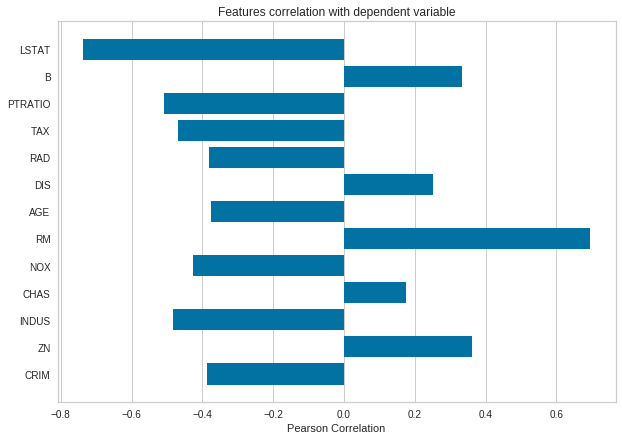

In [11]:
plt.figure(figsize=(10,7))
visualizer = FeatureCorrelation(labels = feature_names,
                               )

visualizer.fit(features, target)

visualizer.poof()

In [30]:
def using_k_best(k, features, target):
    select_univariate = SelectKBest(f_regression, k = k).fit(features, target)
    
    feature_mask = select_univariate.get_support()
    
    return pd.DataFrame({'KBest': features.columns,
                         'Score' : select_univariate.scores_}
                       ).sort_values(by='Score', ascending=False).head(k)

In [31]:
best_5_features = using_k_best(6, features, target)
best_5_features

,KBest,Score
12,LSTAT,601.617871
5,RM,471.846740
10,PTRATIO,175.105543
2,INDUS,153.954883
9,TAX,141.761357
4,NOX,112.591480


In [32]:
# Wrapper method 
# Recursive Feature Elimination
def using_rfe(estimator, num_of_features, step, features, target): 
    rfe = RFE(estimator=estimator,
             n_features_to_select=num_of_features,
             step=step)
    
    rfe.fit(features, target)
    
    rfe_features = features.columns[rfe.support_]
    
    return pd.DataFrame({'RFe': features.columns,
                        'Rank' : rfe.ranking_}).sort_values(by='Rank')

In [33]:
best_using_rfe = using_rfe(RandomForestRegressor(), 5, 1, features, target)
best_using_rfe

,RFe,Rank
0,CRIM,1
4,NOX,1
5,RM,1
7,DIS,1
12,LSTAT,1
10,PTRATIO,2
6,AGE,3
9,TAX,4
11,B,5
2,INDUS,6


In [34]:
def using_mlxtend(estimator, num_of_features, forward, scoring, features, target):
    feature_selector = SequentialFeatureSelector(estimator=estimator,
                                                k_features=num_of_features,
                                                forward=forward,
                                                scoring=scoring,
                                                cv = 4)
    
    featured_filtered = feature_selector.fit(features, target)
    
    backward_features = list(featured_filtered.k_feature_names_)
    
    return pd.DataFrame({'Backward Method': backward_features})

In [35]:
best_using_mlxtend = using_mlxtend(RandomForestRegressor(), 5, True, 'neg_mean_squared_error', features, target)
best_using_mlxtend

,Backward Method
0,NOX
1,RM
2,RAD
3,PTRATIO
4,LSTAT


In [47]:
final_df = pd.concat([best_5_features.head()['KBest'].reset_index(), best_using_mlxtend.reset_index(), best_using_rfe.head()[['RFe']].reset_index()], axis=1)

In [48]:
best_5_features.head()[['KBest']].reset_index()

,index,KBest
0,12,LSTAT
1,5,RM
2,10,PTRATIO
3,2,INDUS
4,9,TAX


In [50]:
final_df.drop('index', axis=1, inplace=True)

In [51]:
final_df

,KBest,Backward Method,RFe
0,LSTAT,NOX,CRIM
1,RM,RM,NOX
2,PTRATIO,RAD,RM
3,INDUS,PTRATIO,DIS
4,TAX,LSTAT,LSTAT


In [74]:
result = []

def best_score(name, X, Y):
    x_train, x_test, y_train, y_test = train_test_split(X, Y)
    
    linear_model = GradientBoostingRegressor().fit(x_train, y_train)
    
    print(name)
    print('Training Score ', linear_model.score(x_train, y_train))
    
    y_pred = linear_model.predict(x_test)
    print('r2 score', r2_score(y_test, y_pred))

In [75]:
best_score('KBest', features[final_df['KBest'].values], target)

KBest
Training Score  0.9586432715271989
r2 score 0.7733233309920803


In [76]:
best_score('RFe', features[final_df['RFe'].values], target)

RFe
Training Score  0.9692600425569946
r2 score 0.9054659472915364


In [77]:
best_score('Backward Method', features[final_df['Backward Method'].values], target)

Backward Method
Training Score  0.9653696217911347
r2 score 0.8562810758618581
